前回[こちらの記事](https://qiita.com/kei0919/items/bde365bf179c0a1573af)にて青空文庫の書籍をDoc2Vecでクラスタリングしようとしました。  
少しうまくいったかなという程度だったのですが、正直微妙な結果となってしまいました。  
そこで今回はDoc2Vecに代わり、fastTextというライブラリを用いて、Yahooニュース記事のクラスタリングを行おうと思います。

### fastTextとは
fastTextとはFacebookによって開発が行われたオープンソースの自然言語処理ライブラリです。  
高機能で予測精度も良く、更に高速に予測をします。  
メイン機能は教師あり学習による分類と教師なし学習による単語のベクトル生成です。

今回は教師あり学習による分類機能を用いて、記事のカテゴリを予測してみようと思います。

詳しくは[fastText公式リファレンス](https://fasttext.cc/)へ！  
Pythonについての機能は[GitHub](https://github.com/facebookresearch/fastText/tree/master/python)が詳しかったです！

### 開発環境
- Docker → [こちら](https://qiita.com/kei0919/items/d1e975b015efc22b5001)で記事にしています
- JupyterLab

### 実装スタート

In [1]:
import pandas as pd, numpy as np
import re
import MeCab
import fasttext
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
import japanize_matplotlib

### ニュースデータ取得
[Yahooニュースをスクレイピング](https://qiita.com/kei0919/items/780b36f14907412f3489)でご紹介したコードを利用して取得したデータを読み込みます。  
アメリカ大統領選挙の直後ということもあり、国際ニュースが多いですね。

In [2]:
df = pd.read_csv('./YahooNews.csv')
df

,title,category,text
0,損? あざとかわいい吉岡里帆,エンタメ,女優吉岡里帆27の2年ぶり2冊目の写真集里帆採取 by Asami Kiyokawa集英社...
1,鬼滅の「聖地」潤う観光地,経済,コロナ禍にもかかわらず異例の大ヒットを記録している劇場版鬼滅の刃 無限列車編映画にとどまらず...
2,電通G コロナで営業利益半減,経済,電通グループが10日発表した2020年19月期連結決算国際会計基準は売上高に当たる収益が9...
3,香港民主派議員、全員辞職,国際,12 北京共同新華社電によると中国の全人代常務委員会会議は11日香港立法会定数70の議員資格...
4,専門家組織 全国的に感染増加,国内,新型コロナウイルス対策を助言する厚生労働省の専門家組織アドバイザリーボードの会合が11日開...
...,...,...,...
512,ホワイトハウス周辺で4人刺傷,国際,米NBCテレビなどによると米大統領選でトランプ大統領とバイデン前副大統領の双方の支持者が集...
513,一方的な勝利宣言 米の反応は,国際,FNNプライムオンラインアメリカ大統領選挙の投票日から一夜明けた4日午前10時前のワシントン...
514,NY株続伸、一時600ドル超高,国際,ニューヨーク時事開票作業が進む米大統領選でトランプバイデン両候補の大接戦が続く中4日午前の...
515,セガサミー ゲーセン運営撤退,経済,セガサミーホールディングスは4日娯楽施設を運営する連結子会社セガエンタテインメント東京の株...


### 辞書&関数定義

In [3]:
# MeCabの辞書にNEologdを指定。
# mecabは携帯素解析用、wakatiは分かち書き用
mecab = MeCab.Tagger('-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd/')
wakati = MeCab.Tagger("-Owakati -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd/")


# 形態素解析を行う関数を定義
# ファイルを入力するとファイルを出力し、文字列を渡すと文字列を返します。引数fileで変更します。  
# 単に分かち書きしたいだけの場合は引数にmecab=wakatiとすると実現できます。
def MecabMorphologicalAnalysis(path='./text.txt', output_file='wakati.txt', mecab=mecab, file=False):
    mecab_text = ''
    if file:
        with open(path) as f:
            for line in f:
                mecab_text += mecab.parse(line)
        with open(output_file, 'w') as f:
            print(mecab_text, file=f)
    else:
        for path in path.split('\n'):
            mecab_text += mecab.parse(path)
        return mecab_text


# v1とv2のコサイン類似度を出力します。
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

### データ前処理
fastTextで利用するための形に変形します。  
fastTextは下記のような形にデータを整形してあげることで、簡単に教師あり学習を行うことができます。  
詳しくは[公式チュートリアル](https://fasttext.cc/docs/en/supervised-tutorial.html)をご参照ください。


```
__label__sauce __label__cheese how much does potato starch affect a cheese sauce recipe ? 
__label__food-safety __label__acidity dangerous pathogens capable of growing in acidic environments
__label__cast-iron __label__stove how do i cover up the white spots on my cast iron stove ? 
__label__restaurant michelin three star restaurant; but if the chef is not there
```

上記の形に整形するために以下の処理を行います。  
①ニュースのカテゴリの前に`__label__`を挿入 → リストに格納  
②本文は上記で定義した`MecabMorphologicalAnalysis関数`を利用して分かち書き → リストに格納  
③`train_test_split`を用いてtrainデータとvalidデータに分割  
④trainとvalidでそれぞれカテゴリと本文を結合してファイルに保存

In [4]:
# ①
cat_lst = ['__label__' + cat for cat in df.category]
print("cat_lst[:5]:", cat_lst[:5]) # 内容を確認
print("len(cat_lst):", len(cat_lst)) # ラベル数を確認

cat_lst[:5]: ['__label__エンタメ', '__label__経済', '__label__経済', '__label__国際', '__label__国内']
len(cat_lst): 517


In [5]:
# ②
text_lst = [MecabMorphologicalAnalysis(text, mecab=wakati) for text in df.text]
print("text_lst[0][:50]:", text_lst[0][:50]) # 1行目を確認
print("text_lst[1][:50]:", text_lst[1][:50]) # 2行目を確認
print("len(text_lst):", len(text_lst)) # 記事の数を確認

text_lst[0][:50]: 女優 吉岡里帆 27 の 2年ぶり 2 冊 目 の 写真集 里帆 採取 by Asami Kiyok
text_lst[1][:50]: コロナ禍 に も かかわら ず 異例 の 大 ヒット を 記録 し て いる 劇場版 鬼滅の刃 無限
len(text_lst): 517


In [6]:
# ③
text_train, text_valid, cat_train, cat_valid = train_test_split(
    text_lst, cat_lst, test_size=0.2, random_state=0, stratify=cat_lst
)


# ④
with open('./news.train', mode='w') as f:
    for i in range(len(text_train)):
        f.write(cat_train[i] + ' '+ text_train[i])
        
with open('./news.valid', mode='w') as f:
    for i in range(len(text_valid)):
        f.write(cat_valid[i] + ' ' + text_valid[i])

### モデルの学習と評価
fastTextは`train_supervised`で簡単に学習を行うことができます。  
wordNgramsに引数を渡すことでn-gram処理を行ったり、lossにhsを入れて`hierarchical softmax`を使って高速に処理を行ったり、とにかく高機能です！！  

学習も素晴らしいのですが、`model.test`とするとすぐに精度の評価ができることもfastTextの特徴だと思います。  
下記に示す通りvalidデータに対してもなかなか良い精度が出るということがわかります。

In [7]:
model = fasttext.train_supervised(input='./news.train', lr=0.5, epoch=500,
                                  wordNgrams=3, loss='ova', dim=300, bucket=200000)

print("TrainData:", model.test('news.train'))
print("Valid", model.test('news.valid'))

TrainData: (413, 1.0, 1.0)
Valid (104, 0.75, 0.75)


### validデータを用いた精度確認
学習に用いていないvalidデータを用いて、モデルの精度を確認してみましょう。  
①validデータの内容をl_stripに格納  
②label,text,sizeをそれぞれリストに格納。labelはニュースのカテゴリ、textは本文、sizeはモデルの予測に対する確率です。正規表現を用いて必要な部分を抽出しています。  
③ニュースを一つづつ取り出して、カテゴリ予測をしてみます。`predict`の引数kの数だけ候補を表示します。その下のarrayにはモデルが行った予測に対する確率が順番に表示されます。

In [8]:
# ①
with open("news.valid") as f:
    l_strip = [s.strip() for s in f.readlines()] # strip()を利用することにより改行文字除去
    

# ②    
labels = []
texts = []
sizes = []
for t in l_strip:
    labels.append(re.findall('__label__(.*?) ', t)[0])
    texts.append(re.findall(' (.*)', t)[0])
    sizes.append(model.predict(re.findall(' (.*)', t))[1][0][0])

In [20]:
# ③
print("<{}>".format(labels[0]))
print(texts[0])
print(model.predict(texts[0], k=3))

<経済>
電通グループ が 10日 発表 し た 2020年 19 月 期 連結決算 国際会計基準 は 売上高 に 当たる 収益 が 94 減 の 6763 億 円 本業 の もうけ を 示す 営業利益 は 185 億 円 に 半減 し た 新型コロナウイルス感染症 の 影響 を 受け 国内外 で テレビ や インターネット 向け など の 広告 需要 が 落ち込ん だ 営業利益 の 半減 は 年末 から 来年3月 にかけて 実施 する 早期退職 プログラム の ほか 退職者 向け に 業務委託 を 手掛ける 新 会社設立 など の 構造改革 費用 251 億 円 を 計上 し た ため 一方 コロナ禍 で 一連 の MA 合併 買収 費用 が 想定 を 下回る 結果 純利益 は 22倍 の 102 億 円 を 確保 し た 2月 に 子会社化 を 決め た 米メディア ストーム 社 を はじめ 多く の 企業価値 が 下落 し 株式 の 追加 取得 に かかる 見積 費 が 約 300億円 減少 し た
(('__label__経済', '__label__国内', '__label__ライフ'), array([9.88678277e-01, 1.48057193e-01, 3.89984576e-04]))


In [23]:
print("<{}>".format(labels[1]))
print(texts[1])
print(model.predict(texts[1], k=3))

<経済>
任天堂 は 5日 家庭 用 ゲーム機 ニンテンドースイッチ の 世界 で の 累計 販売台数 が 9月 末 時点 で 6830 万 台 に なっ た と 発表 し た ファミリーコンピュータ ファミコン の 6191 万 台 を 上回っ た 新型コロナウイルス の 感染拡大 に 伴う 巣ごもり消費 が 追い風 と なり 2017年 3月 の 発売 から 約 3年 半 で 達成 し た スイッチ は 据え置い て も 持ち運ん で も ゲーム が でき 幅広い 世代 から 支持 さ れ た 今年3月 に 発売 し た ソフト あつまれ どうぶつの森 が ヒット し て スイッチ の 販売 を 押し上げ た スイッチ は 20年 49 月 だけ で 1253 万 台 が 売れ た
(('__label__経済', '__label__スポーツ', '__label__国内'), array([0.00338661, 0.00206074, 0.00081409]))


In [24]:
print("<{}>".format(labels[2]))
print(texts[2])
print(model.predict(texts[2], k=3))

<スポーツ>
JERA セリーグ 巨人 6 ― 2 ヤクルト 7日 東京ドーム 今季限り で 現役 引退 する 巨人 の 岩隈久志 投手 39 の 引退セレモニー が 7日 の ヤクルト 23回 戦 東京ドーム の 試合後 に 行わ れ た 今季 最多 と なる 2 万 6649 人 の ファン の 前 で 岩隈 は 本日 をもちまして 21年間 の プロ野球 生活 に 幕 を 閉じ ます 21年間 すばらしい チームメート に 恵まれ 最高 の 野球 人生 を 送る こと が でき 感謝 の 思い で いっぱい です と 語っ た そして この 2年間 ジャイアンツ で 1軍 復帰 する こと は でき ませ ん でし た が 現役 最後 に ジャイアンツ の ユニホーム を 着 て この 日 を 迎え られ た こと に 幸せ を 感じ て い ます これから も 野球 を通じて 誰か を 幸せ に できる 存在 で い たい と 思い ます 21年間 本当にありがとうございました と スピーチ し た その後 は 現在 ヤクルト で マリナーズ 時代 の チームメート 青木 楽天 で 一緒 に プレー し た 嶋 から 花束 を 受け取っ た さら に 菅野 から も 花束 を 受け取る と 続け て 原監督 が 自ら 岩隈 の 元 へ 駆け寄り ナイン と 一緒に 記念撮影 を 行っ た そして 最後 は 3人 の 子どもたち から も 花束 を 受け取り 再び 記念撮影 を し て ファン に 別れ を 告げ て い た 報知新聞社
(('__label__スポーツ', '__label__エンタメ', '__label__ライフ'), array([8.55861187e-01, 1.00888625e-01, 7.65405654e-04]))


### ベクトル表現についての分析
ここまでで分析を終わりにしても良いのですが、fastTextの`get_sentence_vector`という機能を使って記事ごとのベクトルを取得して、さらに分析を行ってみましょう。  
①記事一つ一つに対してベクトルを取得し、リストに格納していきます。  
②ベクトル、ラベル、サイズをnumpy配列に変更します。(ラベル、サイズについては取得済)  
③`StandardScaler`を用いてベクトルを標準化  
④主成分分析器`PCA`を用いて次元削減  
⑤上記で定義した`cos_sim関数`を用いて記事ごとの類似度を算出  
⑥ベクトルを2次元プロット。sizesの数値によって点の大きさが変化します。

In [15]:
# ①
vectors = []
for t in texts:
    vectors.append(model.get_sentence_vector(t))

    
# ②
vectors = np.array(vectors)
labels = np.array(labels)
sizes = np.array(sizes)


# ③
ss = preprocessing.StandardScaler()
vectors_std = ss.fit_transform(vectors)


# ④
pca = PCA()
pca.fit(vectors_std)
feature = pca.transform(vectors_std)
feature = feature[:, :2]

In [16]:
# ⑤
print("<{}><{}>".format(labels[0], labels[1]))
cos_sim(vectors[0], vectors[1])

<経済><経済>


0.9514279

In [17]:
print("<{}><{}>".format(labels[1], labels[2]))
cos_sim(vectors[1], vectors[2])

<経済><スポーツ>


0.9299138

In [18]:
print("<{}><{}>".format(labels[0], labels[2]))
cos_sim(vectors[0], vectors[2])

<経済><スポーツ>


0.79527444

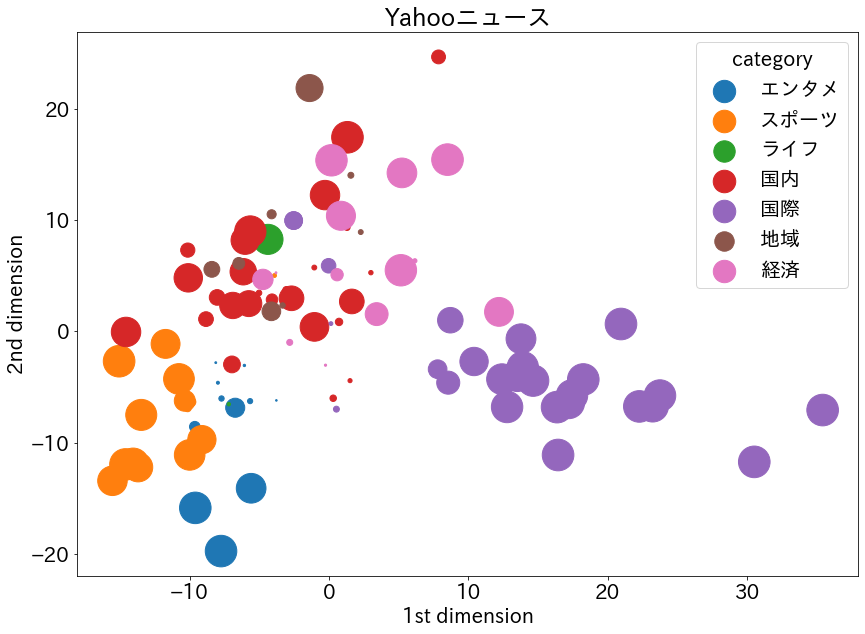

In [42]:
# ⑥
x0, y0, z0 = feature[labels=='エンタメ', 0], feature[labels=='エンタメ', 1], sizes[labels=='エンタメ']*1000
x1, y1, z1 = feature[labels=='スポーツ', 0], feature[labels=='スポーツ', 1], sizes[labels=='スポーツ']*1000
x2, y2, z2 = feature[labels=='ライフ', 0], feature[labels=='ライフ', 1], sizes[labels=='ライフ']*1000
x3, y3, z3 = feature[labels=='国内', 0], feature[labels=='国内', 1], sizes[labels=='国内']*1000
x4, y4, z4 = feature[labels=='国際', 0], feature[labels=='国際', 1], sizes[labels=='国際']*1000
x5, y5, z5 = feature[labels=='地域', 0], feature[labels=='地域', 1], sizes[labels=='地域']*1000
x6, y6, z6 = feature[labels=='経済', 0], feature[labels=='経済', 1], sizes[labels=='経済']*1000


plt.figure(figsize=(14, 10))
plt.rcParams["font.size"]=20
plt.scatter(x0, y0, label="エンタメ", s=z0)
plt.scatter(x1, y1, label="スポーツ", s=z1)
plt.scatter(x2, y2, label="ライフ", s=z2)
plt.scatter(x3, y3, label="国内", s=z3)
plt.scatter(x4, y4, label="国際", s=z4)
plt.scatter(x5, y5, label="地域", s=z5)
plt.scatter(x6, y6, label="経済", s=z6)
plt.title("Yahooニュース")
plt.xlabel('1st dimension')
plt.ylabel('2nd dimension')
plt.legend(title="category")
plt.show()

### 参考文献
[青空文庫の書籍をDoc2Vecでクラスタリング](https://qiita.com/kei0919/items/bde365bf179c0a1573af)  
[fastText](https://fasttext.cc/)  
[GitHub (fastText/python)](https://github.com/facebookresearch/fastText/tree/master/python)  
[mecab(NEologd辞書)環境をDocker(ubuntu)で構築](https://qiita.com/kei0919/items/d1e975b015efc22b5001)  
[Yahooニュースをスクレイピング](https://qiita.com/kei0919/items/780b36f14907412f3489)  
[fastText tutorial(Text classification)](https://fasttext.cc/docs/en/supervised-tutorial.html)  
[【Python NumPy】コサイン類似度の求め方](https://qiita.com/Qiitaman/items/fa393d93ce8e61a857b1)   
[主成分分析を Python で理解する](https://qiita.com/maskot1977/items/082557fcda78c4cdb41f)  
[matplotlib Scatter plots with a legend](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/scatter_with_legend.html)